In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt 
import random
import copy  # array-copying convenience
import sys  # max float
import pandas as pd 
from typing import Tuple, List, Dict
%matplotlib inline

In [2]:
import time
def timer(func):                          #mesur le temps d'execution
    def wrapper_timer(*args, **kwargs):
        tic = time.process_time()
        value = func(*args, **kwargs)
        toc = time.process_time()
        return value, toc - tic
    return wrapper_timer



In [3]:
Graph = np.array([                           
     [ False, True, False, False, False, False, False, False],
     [ True, False, True, False, False, False, False, True],
     [ False, True, False, True, False, False, False, False],
     [ False, False, True, False, True, False, False, False],
     [ False, False, False, True, False, True, True, False],
     [ False, False, False, False, True, False, False, False],
     [ False, False, False, False, True, False, False, True],
     [ False, True, False, False, False, False, True, False],
])
Soluce = np.array([0, 1, 0, 1, 0, 1, 1, 0])

In [4]:
def from_file(file_path)-> np.ndarray:
        with open(file_path) as f:
            line = f.readline()
            while line[0] != "p":
                line = f.readline()
            n = int(line.split()[2])
            adj_mat = []
            for i in range(0,n):
                adj_mat.append([False]*n)
            for line in f:
                if line[0] == "e":
                    w, v = map(int, line.split()[1:])
                    adj_mat[w-1][v-1] = adj_mat[v-1][w-1] = True
        return np.array(adj_mat)

In [5]:
#Ecrire la solution dans un fichier 
def to_file(file_path , Soluce , temps , XG):                                                                   
  with open(file_path,"w") as f:
    f.write( "# Solution " )
    f.write( "Minimum number of colors used : " + str(XG) + "\n" )
    f.write( "Processing time :: "+ str(temps) + "\n" )
    f.write( "Color Affectation to the nodes : \n")
    [f.write( "Node "+ str(i)+ " :: "+str(Soluce[i]) +"\n") for i in range(0,len(Soluce))]
  return

In [6]:
#Node Adjacent
def Adjacents(Graph,i):
    Adj = []
    [Adj.append(j) if Graph[i][j] else None for j in range(0,len(Graph))]
    return Adj
Adjacents(Graph,1)

[0, 2, 7]

In [27]:
def nb_conflicts(G: np.ndarray, soluce: np.ndarray)-> int:
    nb = 0
    if(soluce.shape[0] < G.shape[0]):
        print("Problem : ",G.shape[0] ,",G.shape[0] ",soluce.shape[0])
    for i in range(G.shape[0]):
        for j in range(i):
            if(G[i][j] and soluce[i] == soluce[j]):
                nb = nb + 1
    return nb


In [8]:
def Colors(Soluce : np.ndarray)-> Tuple[np.ndarray, int] :
    couleurs = np.unique(Soluce)
    return couleurs

In [9]:
def random_Soluce(Graph : np.ndarray )-> np.ndarray:
    Soluce = []
    for i in range(len(Graph)):
        Soluce.append(random.random()*len(Graph))
    return np.array(Soluce)
 

In [28]:
def fitness_colors(Graph : np.ndarray, Soluce : np.ndarray,poid_conflits: float = 1.)->  int:
    round_Soluce = np.fix(Soluce)
    nb_colors = len(Colors(round_Soluce))
    nb_conflit = nb_conflicts(Graph , round_Soluce)
    return nb_colors + nb_conflit*poid_conflits , nb_conflit

In [18]:
#Dict of colors in a soluce, used in VNS
def count_colors(Soluce):
    count_color = {}
    for color in Soluce:
        if color in count_color.keys():
            count_color[color]+=1
        else :
            count_color[color] = 1
    return count_color

In [12]:
#Affecter la couleur dans la recherche local
def assign_color(Graph,Soluce,count_color,noeud):
    Adjs = Adjacents(Graph,noeud)
    cpt_col = 0
    choosen_col = Soluce[noeud]
    nbc = len(count_color.keys())
    for color in count_color.keys():#pour chaque couleur
        #If no adjacent nodes with this color
        possible = True
        for adj in Adjs:
            if color == Soluce[adj]:
                possible = False
                break
        if possible : #Si on peut affecter la couleur
            if count_color[color] > cpt_col:
                choosen_col = color
                cpt_col = count_color[color]
    #Affecter la couleur au noeud
    old_col = Soluce[noeud]
    count_color[ Soluce[noeud] ]-=1
    Soluce[noeud] = choosen_col
    count_color[choosen_col]+=1
    if count_color[ old_col ]  == 0 :
        count_color.pop(old_col)
    return Soluce,count_color

In [19]:
#Variable neighbourhood  searsh <==> Local search
def proc_VNS(Graph , init_Soluce , max_stagnation , max_iter):
    count_color = count_colors(init_Soluce)
    best_soluce = init_Soluce
    best_fitness = len(count_color.keys())
    V = len(Graph)
    for Iter in range(max_iter):
        count_coleur = count_colors(init_Soluce)
        fitness =  len(count_color.keys())
        Soluce = init_Soluce
        k = 1
        while (k <= max_stagnation):
            noeud = random.randint(0, V - 1)
            new_Soluce , count_color = assign_color(Graph,Soluce,count_color,noeud)
            new_fitness = len(count_color.keys())
            if new_fitness < fitness:
                fitness = new_fitness
                k = 1
                Soluce = new_Soluce
                if(fitness < best_fitness):
                    best_fitness = fitness
                    best_soluce = Soluce
            else :
                k = k + 1
    return np.array(best_soluce), best_fitness  

In [14]:
# whale class
class whale:
    def __init__(self, fitness, dim, minx, maxx, seed,graphe,weight):
        self.weight_conflit = weight
        self.graphe = graphe
        self.rnd = random.Random(seed)
        self.position = [0.0 for i in range(dim)]
        for i in range(dim):
            self.position[i] = ((maxx - minx) * self.rnd.random() + minx)
        fitness ,conflicts = fitness(graphe,self.position,self.weight_conflit) # curr fitness
        self.fitness = fitness
        self.conflicts = conflicts
        


In [15]:
# whale optimization algorithm(WOA)
def woa(fitness, max_iter, n, dim, minx, maxx,graphe,weight):
    rnd = random.Random(0)
 
    # create n random whales
    whalePopulation = [whale(fitness, dim, minx, maxx, i,graphe,weight) for i in range(n)]
 
    # compute the value of best_position and best_fitness in the whale Population
    Xbest = [0.0 for i in range(dim)]
    Fbest = sys.float_info.max
 
    for i in range(n):  # check each whale
        if whalePopulation[i].fitness < Fbest:
            Fbest = whalePopulation[i].fitness
            Xbest = copy.copy(whalePopulation[i].position)
 
    # main loop of woa
    Iter = 0
    while Iter < max_iter:
 
        # after every 10 iterations
        # print iteration number and best fitness value so far
        #if Iter % 10 == 0 and Iter > 1:
        #    print("Iter = " + str(Iter) + " best fitness = %.3f" % Fbest)
 
        # linearly decreased from 2 to 0
        a = 2 * (1 - Iter / max_iter)
        a2=-1+Iter*((-1)/max_iter)
 
        for i in range(n):
            A = 2 * a * rnd.random() - a
            C = 2 * rnd.random()
            b = 1
            l = (a2-1)*rnd.random()+1;
            p = rnd.random()
         
            D = [0.0 for i in range(dim)]
            D1 = [0.0 for i in range(dim)]
            Xnew = [0.0 for i in range(dim)]
            Xrand = [0.0 for i in range(dim)]
            wi = math.exp(Iter / (max_iter - 1))
            if p < 0.5:
                if abs(A) > 1:
                    for j in range(dim):
                        D[j] = abs(C * Xbest[j] - whalePopulation[i].position[j])
                        Xnew[j] = Xbest[j] - wi * A * D[j]
                else:
                    p = random.randint(0, n - 1)
                    while (p == i):
                        p = random.randint(0, n - 1)
 
                    Xrand = whalePopulation[p].position
 
                    for j in range(dim):
                        D[j] = abs(C * Xrand[j] - whalePopulation[i].position[j])
                        Xnew[j] = Xrand[j] - wi * A * D[j]
            else:
                for j in range(dim):
                    D1[j] = abs(Xbest[j] - whalePopulation[i].position[j])
                    Xnew[j] = wi * D1[j] * math.exp(b * l) * math.cos(2 * math.pi * l) + Xbest[j]
 
            for j in range(dim):
                whalePopulation[i].position[j] = Xnew[j]
 
        for i in range(n):
            # if Xnew < minx OR Xnew > maxx
            # then clip it
            for j in range(dim):
                whalePopulation[i].position[j] = max(whalePopulation[i].position[j], minx)
                whalePopulation[i].position[j] = min(whalePopulation[i].position[j], maxx)
 
            whalePopulation[i].fitness = fitness(whalePopulation[i].graphe,whalePopulation[i].position,whalePopulation[i].weight_conflit )[0]
 
            if (whalePopulation[i].fitness < Fbest):
                Xbest = copy.copy(whalePopulation[i].position)
                Fbest = whalePopulation[i].fitness
 
 
        Iter += 1
    # end-while
 
    # returning the best solution
    return Xbest,Fbest

In [29]:

# Variable neighbourhood search Disturbed Whale Optimization algorithm(VDWOA)
def vdwoa(fitness, max_iter, n, dim, minx, maxx,graphe,weight=1,epsilon=0.5,vns_iteration=50):
    bestAgents = np.zeros(max_iter)
    record_conflicts = np.zeros(max_iter)
    rnd = random.Random(0)
 
    # create n random whales
    whalePopulation = [whale(fitness, dim, minx, maxx, i,graphe,weight) for i in range(n)]
 
    # compute the value of best_position and best_fitness in the whale Population
    Xbest = [0.0 for i in range(dim)]
    Fbest = sys.float_info.max
 
    for i in range(n):  # check each whale
        if whalePopulation[i].fitness < Fbest:
            Fbest = whalePopulation[i].fitness
            Xbest = copy.copy(whalePopulation[i].position)
            Fconflicts = whalePopulation[i].conflicts
 
    # main loop of woa
    Iter = 0
    while Iter < max_iter:
 
        # after every 10 iterations
        # print iteration number and best fitness value so far
        if Iter % 2 == 0 and Iter > 1:
           print("Iter = " + str(Iter) + " best fitness = ", Fbest)
 
        # linearly decreased from 2 to 0
        a = 2 * (1 - Iter / max_iter)
        a2=-1+Iter*((-1)/max_iter)
 
        for i in range(n):
            r = rnd.random()
            A = 2 * a * rnd.random() - a
            C = 2 * rnd.random()
            b = 1
            l = (a2-1)*rnd.random()+1;
            p = rnd.random()
            D = [0.0 for i in range(dim)]
            D1 = [0.0 for i in range(dim)]
            Xnew = [0.0 for i in range(dim)]
            Xrand = [0.0 for i in range(dim)]
            wi = math.exp(Iter / (max_iter - 1))
            if p < 0.5:
                if abs(A) < 1:
                    for j in range(dim):
                        D[j] = abs(C * Xbest[j] - whalePopulation[i].position[j])
                        Xnew[j] = Xbest[j] - wi * A * D[j]
                else: # |A| <= 1
                    if r < 0.5:
                        # eq 15 : X(t+1) = X_best + epsilon * normal_distr_N(0,1) * wi
                        delta = np.random.normal(0, 1, dim)
                        for j in range(dim):
                            Xnew[j] = Xbest[j] + epsilon* delta[j] * float((max_iter - Iter)/max_iter)
                            if Xnew[j] < 0.:
                                #print("Xnew < 0")
                                Xnew[j] = 0.
                            else:
                                if Xnew[j] >= dim:
                                    #print("Xnew >= dim = ",dim)
                                    Xnew[j] = dim - 1
                    else :
                        # eq 12 :  X(t+1) = Xrand - wi * A * D
                        p = random.randint(0, n - 1)
                        while (p == i):
                            p = random.randint(0, n - 1)
                        Xrand = whalePopulation[p].position
                        for j in range(dim):
                            D[j] = abs(C * Xrand[j] - whalePopulation[i].position[j])
                            Xnew[j] = Xrand[j] - wi * A * D[j]
                    if r > 0.5 : 
                        #Update the local optimal solution
                        Xnew = proc_VNS(graphe , np.fix(Xnew) , 3, vns_iteration)[0]
                        
            else: # p > 0.5
                if r < 0.5 :
                    # eq 15 : X(t+1) = X_best + epsilon * normal_distr_N(0,1) * wi
                    delta = np.random.normal(0, 1, dim)
                    for j in range(dim):
                        Xnew[j] = Xbest[j] + epsilon* delta[j] * float((max_iter - Iter)/max_iter)
                        if Xnew[j] < 0.:
                        #   print("Xnew < 0")
                            Xnew[j] = 0.
                        else:
                            if Xnew[j] >= dim:
                        #        print("Xnew >= dim = ",dim)
                                Xnew[j] = dim - 1
                else : 
                    for j in range(dim):
                        D1[j] = abs(Xbest[j] - whalePopulation[i].position[j])
                        Xnew[j] = wi * D1[j] * math.exp(b * l) * math.cos(2 * math.pi * l) + Xbest[j]
                if r > 0.5 : 
                    Xnew = proc_VNS(graphe , np.fix(Xnew) , 3 , vns_iteration)[0]
                    #Xbest,Fbest = proc_VNS(graphe , np.fix(Xbest) , 3 , 100)
                    
 
            for j in range(dim):
                whalePopulation[i].position[j] = Xnew[j]
 
        for i in range(n):
            # if Xnew < minx OR Xnew > maxx
            # then clip it
            for j in range(dim):
                whalePopulation[i].position[j] = max(whalePopulation[i].position[j], minx)
                whalePopulation[i].position[j] = min(whalePopulation[i].position[j], maxx)
 
            whalePopulation[i].fitness,whalePopulation[i].conflicts = fitness(whalePopulation[i].graphe,whalePopulation[i].position,whalePopulation[i].weight_conflit )
 
            if (whalePopulation[i].fitness < Fbest):
                Xbest = copy.copy(whalePopulation[i].position)
                Fbest = whalePopulation[i].fitness
                Fconflicts = whalePopulation[i].conflicts
 
        bestAgents[Iter] = Fbest
        record_conflicts[Iter] = Fconflicts
        Iter += 1
    # end-while
 
    # returning the best solution
    return Xbest,Fbest,bestAgents,record_conflicts

In [32]:
folder = "Instances/"
# VDWOA Driver code for coloring graph
Graph = from_file(folder + "queen5_5.col")
print("\nBegin whale optimization algorithm on Graph Coloring\n")
dim = len(Graph)
fitness = fitness_colors
 
print("Goal is to minimize Chromatic number of a graphe with " + str(dim) + " nodes")
 
num_whales = 100
max_iter = 20

print("Setting num_whales = " + str(num_whales))
print("Setting max_iter    = " + str(max_iter))
print("\nStarting WOA algorithm\n")
to = time.time()
best_position,best_fitness,fitness_agents,record_conflicts = vdwoa(fitness, max_iter, num_whales, dim, 0, dim,Graph,len(Graph),0.5,80)
t1 = time.time()
print("\nVDWOA completed\n")
print("\nBest solution found:")
print(best_position )
print("fitness of best solution = ",int(best_fitness))
print("Number of Conflicts",record_conflicts[len (record_conflicts) - 1])

print("\nEnd VDWOA for Graphe coloring\n")


Begin whale optimization algorithm on Graph Coloring

Goal is to minimize Chromatic number of a graphe with 25 nodes
Setting num_whales = 100
Setting max_iter    = 20

Starting WOA algorithm

Iter = 2 best fitness =  5
Iter = 4 best fitness =  5
Iter = 6 best fitness =  5
Iter = 8 best fitness =  5
Iter = 10 best fitness =  5
Iter = 12 best fitness =  5
Iter = 14 best fitness =  5
Iter = 16 best fitness =  5
Iter = 18 best fitness =  5

VDWOA completed


Best solution found:
[4.0, 24.0, 25, 10.0, 14.0, 10.0, 14.0, 4.0, 24.0, 25, 24.0, 25, 10.0, 14.0, 4.0, 14.0, 4.0, 24.0, 25, 10.0, 25, 10.0, 14.0, 4.0, 24.0]
fitness of best solution =  5
Number of Conflicts 0.0

End VDWOA for Graphe coloring



In [133]:
# WOA Driver code for coloring graph
Graph = from_file("miles250.col")
print("\nBegin whale optimization algorithm on Graph Coloring Version 2 \n")
dim = len(Graph)
fitness = fitness_colors
 
print("Goal is to minimize Chromatic number of a graphe with " + str(dim) + " nodes")
print("XG of Graphe is  2")
 
num_whales = 100
max_iter = 200
 
print("Setting num_whales = " + str(num_whales))
print("Setting max_iter    = " + str(max_iter))
print("\nStarting WOA algorithm\n")
 
best_position = woa(fitness, max_iter, num_whales, dim, 0, dim,Graph,len(Graph))[0]

print("Solution obtenu a des conflits : ",nb_conflits(Graph,np.fix(best_position)))
print("\nWOA completed\n")
print("\nBest solution found:")
print(["%d" % int(best_position[k]) for k in range(dim)])
err = fitness(Graph,best_position,1)
print("fitness of best solution = ",int(err))
 
print("\nEnd WOA for Graphe coloring\n")


Begin whale optimization algorithm on Graph Coloring Version 2 

Goal is to minimize Chromatic number of a graphe with 128 nodes
XG of Graphe is  2
Setting num_whales = 100
Setting max_iter    = 200

Starting WOA algorithm

Solution obtenu a des conflits :  0

WOA completed


Best solution found:
['30', '26', '40', '48', '41', '19', '52', '24', '17', '7', '23', '9', '13', '27', '39', '38', '7', '5', '12', '23', '42', '36', '49', '33', '30', '15', '17', '10', '23', '34', '33', '24', '24', '14', '38', '33', '37', '39', '14', '6', '15', '47', '42', '22', '39', '18', '42', '6', '38', '50', '23', '26', '9', '15', '16', '13', '4', '14', '5', '24', '18', '16', '46', '16', '32', '40', '38', '49', '33', '44', '4', '33', '19', '20', '34', '38', '20', '18', '15', '48', '34', '15', '30', '4', '15', '31', '56', '39', '30', '37', '15', '32', '55', '8', '46', '50', '22', '36', '53', '8', '26', '30', '40', '16', '38', '31', '42', '35', '44', '25', '31', '28', '22', '25', '28', '21', '10', '20', '48',

In [ ]:
#Parameters
nb_runs = 10
fitness = fitness_colors
g = from_file("queen9_9.col")
optimal = 10
dim = g.shape[0]
weight = g.shape[0]
epsilon = 0.5
vnc_iterations = 40
max_iter = 20
x = np.arange(1, max_iter+1)

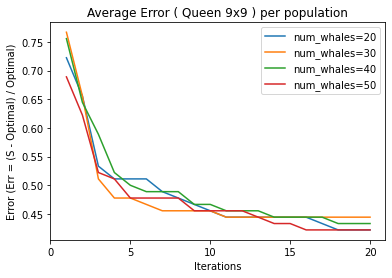

In [25]:

fig, ax = plt.subplots()
f = open("wao_parameters/whale_population_tmp.npy", "wb")
whale_populations = np.arange(20, 51, 10)
np.save(f, whale_populations)
def plot_population_avg_err(fitness, max_iter, whale_populations, dim,g,weight,epsilon,vnc_iterations,nb_runs=10):
    for population in whale_populations:
        total_fitness = np.zeros( max_iter )
        for _ in range(nb_runs):
            best_position,best_fitness,fitness_agents,record_conflicts = vdwoa(fitness, max_iter, population, dim, 0, dim,g,weight,epsilon,vnc_iterations)
            total_fitness += (fitness_agents - optimal)/optimal
        total_fitness /= nb_runs
        np.save(f, total_fitness)
        ax.plot(x, total_fitness, label=f"num_whales={population}")
plot_population_avg_err(fitness,max_iter,whale_populations,dim,g,weight,epsilon,vnc_iterations,10)
f.close()
ax.set_xticks(np.arange(0, max_iter+1, 5))
ax.set_title("Average Error ( Queen 9x9 ) per population")
ax.set_xlabel("Iterations")
ax.set_ylabel("Error (Err = (S - Optimal) / Optimal)")
ax.legend()
fig.savefig("wao_parameters/rand_populations_tmp.pdf", bbox_inches="tight")

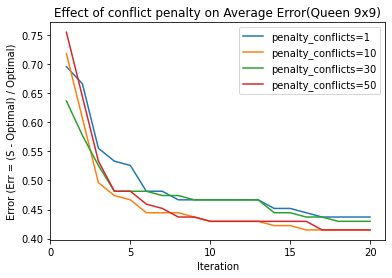

In [31]:
#Parameters
nb_runs = 15
g = from_file("queen9_9.col")
dim = g.shape[0]
weight = g.shape[0]
num_whales = 20
epsilon = 0.5
vnc_iterations = 50
max_iter = 20
x = np.arange(1, max_iter+1)
fig, ax = plt.subplots()

f = open("wao_parameters/penalty_conflicts.npy", "wb")

weights = [1,10,30,50]
np.save(f, weights)
for w in weights:
    total_fitness = np.zeros( max_iter )
    for _ in range(nb_runs):
        best_position,best_fitness,fitness_agents,record_conflicts = vdwoa(fitness, max_iter,num_whales, dim, 0, dim,g,w,epsilon,vnc_iterations)
        total_fitness += (fitness_agents - optimal)/optimal 
    total_fitness /= nb_runs
    np.save(f, total_fitness)
    ax.plot(x, total_fitness, label=f"penalty_conflicts={w}")

f.close()
ax.set_xticks(np.arange(0, max_iter+1, 5))
ax.set_title("Effect of conflict penalty on Average Error(Queen 9x9)")
ax.set_xlabel("Iteration")
ax.set_ylabel("Error (Err = (S - Optimal) / Optimal)")
ax.legend()
fig.savefig("wao_parameters/penalty_conflicts.pdf", bbox_inches="tight")

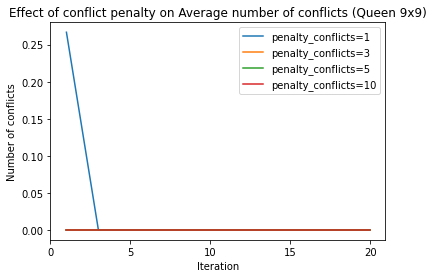

In [157]:
#Parameters
nb_runs = 15
g = from_file("queen9_9.col")
dim = g.shape[0]
weight = g.shape[0]
num_whales = 20
epsilon = 0.5
vnc_iterations = 50
max_iter = 20
x = np.arange(1, max_iter+1)
fig, ax = plt.subplots()

f = open("wao_parameters/penalty_conflicts2.npy", "wb")

weights = [1,3,5,10]
np.save(f, weights)
for w in weights:
    total_fitness = np.zeros( max_iter )
    for _ in range(nb_runs):
        best_position,best_fitness,fitness_agents,record_conflicts = vdwoa(fitness, max_iter,num_whales, dim, 0, dim,g,w,epsilon,vnc_iterations)
        total_fitness += record_conflicts 
    total_fitness /= nb_runs
    np.save(f, total_fitness)
    ax.plot(x, total_fitness, label=f"penalty_conflicts={w}")

f.close()
ax.set_xticks(np.arange(0, max_iter+1, 5))
ax.set_title("Effect of conflict penalty on Average number of conflicts (Queen 9x9)")
ax.set_xlabel("Iteration")
ax.set_ylabel("Number of conflicts")
ax.legend()
fig.savefig("wao_parameters/penalty_conflicts2.pdf", bbox_inches="tight")

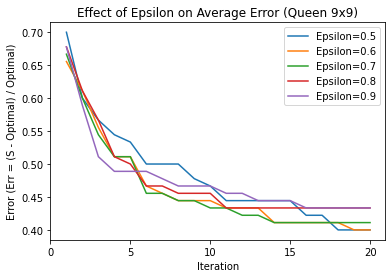

In [37]:
#Parameters
nb_runs = 10
g = from_file("queen9_9.col")
dim = g.shape[0]
weight = 10
num_whales = 20
vnc_iterations = 50
max_iter = 20
epsilon_values = np.arange(0.5, 0.91, 0.1).round(2)
x = np.arange(1, max_iter+1)
fig, ax = plt.subplots()

f = open("wao_parameters/epsilon_variation.npy", "wb")


np.save(f, epsilon_values)
for epsilon in epsilon_values:
    total_fitness = np.zeros( max_iter )
    for _ in range(nb_runs):
        best_position,best_fitness,fitness_agents = vdwoa(fitness, max_iter,num_whales, dim, 0, dim,g,weight,epsilon,vnc_iterations)
        total_fitness += (fitness_agents - optimal)/optimal 
    total_fitness /= nb_runs
    np.save(f, total_fitness)
    ax.plot(x, total_fitness, label=f"Epsilon={epsilon}")

f.close()
ax.set_xticks(np.arange(0, max_iter+1, 5))
ax.set_title("Effect of Epsilon on Average Error (Queen 9x9)")
ax.set_xlabel("Iteration")
ax.set_ylabel("Error (Err = (S - Optimal) / Optimal)")
ax.legend()
fig.savefig("wao_parameters/epsilon_variation.pdf", bbox_inches="tight")

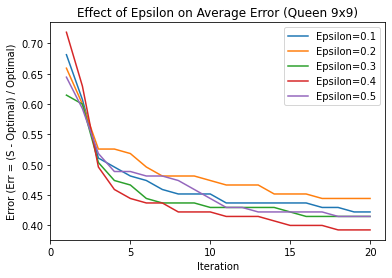

In [35]:
#Parameters
nb_runs = 15
g = from_file("queen9_9.col")
dim = g.shape[0]
weight = 10
num_whales = 20
vnc_iterations = 50
max_iter = 20
epsilon_values = np.arange(0.1, 0.51, 0.1).round(2)
x = np.arange(1, max_iter+1)
fig, ax = plt.subplots()

f = open("wao_parameters/epsilon_variation2.npy", "wb")


np.save(f, epsilon_values)
for epsilon in epsilon_values:
    total_fitness = np.zeros( max_iter )
    for _ in range(nb_runs):
        best_position,best_fitness,fitness_agents = vdwoa(fitness, max_iter,num_whales, dim, 0, dim,g,weight,epsilon,vnc_iterations)
        total_fitness += (fitness_agents - optimal)/optimal 
    total_fitness /= nb_runs
    np.save(f, total_fitness)
    ax.plot(x, total_fitness, label=f"Epsilon={epsilon}")

f.close()
ax.set_xticks(np.arange(0, max_iter+1, 5))
ax.set_title("Effect of Epsilon on Average Error (Queen 9x9)")
ax.set_xlabel("Iteration")
ax.set_ylabel("Error (Err = (S - Optimal) / Optimal)")
ax.legend()
fig.savefig("wao_parameters/epsilon_variation2.pdf", bbox_inches="tight")

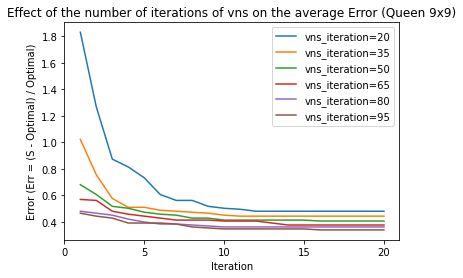

In [43]:
#Parameters
nb_runs = 15
g = from_file("queen9_9.col")
dim = g.shape[0]
weight = 10
num_whales = 20
max_iter = 20
vns_iteration = np.arange(20, 100, 15)
x = np.arange(1, max_iter+1)
fig, ax = plt.subplots()
epsilon = 0.4
f = open("wao_parameters/vns_iteration.npy", "wb")


np.save(f, epsilon_values)
for vns_iter in vns_iteration :
    total_fitness = np.zeros( max_iter )
    for _ in range(nb_runs):
        best_position,best_fitness,fitness_agents,record_conflicts = vdwoa(fitness, max_iter,num_whales, dim, 0, dim,g,weight,epsilon,vns_iter)
        total_fitness += (fitness_agents - optimal)/optimal 
    total_fitness /= nb_runs
    np.save(f, total_fitness)
    ax.plot(x, total_fitness, label=f"vns_iteration={vns_iter}")

f.close()
ax.set_xticks(np.arange(0, max_iter+1, 5))
ax.set_title("Effect of the number of iterations of vns on the average Error (Queen 9x9)")
ax.set_xlabel("Iteration")
ax.set_ylabel("Error (Err = (S - Optimal) / Optimal)")
ax.legend()
fig.savefig("wao_parameters/vns_iteration.pdf", bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


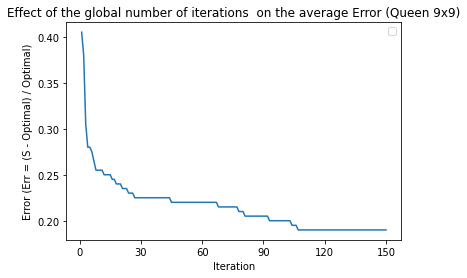

In [135]:
#Parameters
nb_runs = 20
g = from_file("queen9_9.col")
dim = g.shape[0]
weight = 10
optimal = 10
num_whales = 30
max_iter = 150
vns_iteration = 65
x = np.arange(1, max_iter+1)
fig, ax = plt.subplots()
epsilon = 0.4
f = open("wao_parameters/iterations.npy", "wb")


np.save(f, epsilon_values)
total_fitness = np.zeros( max_iter )
for _ in range(nb_runs):
    best_position,best_fitness,fitness_agents,record_conflicts = vdwoa(fitness, max_iter,num_whales, dim, 0, dim,g,weight,epsilon,vns_iteration)
    total_fitness += (fitness_agents - optimal)/optimal 
total_fitness /= nb_runs
np.save(f, total_fitness)
ax.plot(x, total_fitness)

f.close()
ax.set_xticks(np.arange(0, max_iter+1, 30),label=f"iterations={max_iter}")
ax.set_title("Effect of the global number of iterations  on the average Error (Queen 9x9)")
ax.set_xlabel("Iteration")
ax.set_ylabel("Error (Err = (S - Optimal) / Optimal)")
ax.legend()
fig.savefig("wao_parameters/iterations.pdf", bbox_inches="tight")

In [136]:
graphes = ["myciel3.col","myciel4.col","myciel5.col","myciel6.col","myciel7.col","queen5_5.col","queen6_6.col","queen7_7.col"]
optimal = np.array([4,5,6,7,8,5,7,7])
labels = [["Graphe","Optimal Solution","WOA Solution","WOA Conflicts","WOA Execution time","VDWOA Solution","VDWOA Conflicts","VDWOA Execution time"]]
max_iter = 100
num_whales = 30
data = []
for i in range (len(graphes)):
    row = [optimal[i]]
    #woa Solution
    G = from_file(graphes[i])
    dim = G.shape[0]
    t0 = time.time()
    best_position,best_fitness = woa(fitness, max_iter, num_whales, dim, 0, G.shape[0],G,G.shape[0])
    t1 = time.time()
    row.append(best_fitness )
    row.append(nb_conflits(G,np.fix(best_position)))
    row.append(t1-t0)
    t0 = time.time()
    best_position,best_fitness,bestagents,record_conflicts = vdwoa(fitness, max_iter, num_whales, dim, 0, dim,G,10,0.4,80)
    t1 = time.time()
    row.append(best_fitness )
    row.append(nb_conflits(G,np.fix(best_position)))
    row.append(t1-t0)
    data.append(row)
df = np.round(data,2)


In [139]:
import pandas as pd 
woa_err = df[:,1]
vdwoa_err = df[:,4]
woa_conflicts = df[:,2]
vdwoa_conflicts = df[:,5]
woa_time = df[:,3]
vdwoa_time = df[:,6]
pd.DataFrame({
    "Graphes" : [graphes[i] for i in range (0 , len(graphes))],
    "Optimal Solution": [optimal[i] for i in range(len(optimal))],
    "Fitness_WAO": [woa_err[i] for i in range(len(woa_err))],
    "nb_conflicts_WAO": [woa_conflicts[i] for i in range(len(woa_conflicts))],
    "Time_WOA": [woa_time[i] for i in range(len(woa_time))],
    "Fitness_VDWAO": [vdwoa_err[i] for i in range(len(vdwoa_err))],
    "nb_conflicts_VDWAO": [vdwoa_conflicts[i] for i in range(len(vdwoa_conflicts))],
    "Time_VDWOA": [vdwoa_time[i] for i in range(len(vdwoa_time))]
})

,Graphes,Optimal Solution,Fitness_WAO,nb_conflicts_WAO,Time_WOA,Fitness_VDWAO,nb_conflicts_VDWAO,Time_VDWOA
0,myciel3.col,4,5.0,0.0,0.31,4.0,0.0,7.34
1,myciel4.col,5,11.0,0.0,1.81,5.0,0.0,11.42
2,myciel5.col,6,29.0,0.0,1.93,6.0,0.0,10.14
3,myciel6.col,7,147.0,1.0,5.07,7.0,0.0,39.92
4,myciel7.col,8,314.0,1.0,41.45,8.0,0.0,113.86
5,queen5_5.col,5,15.0,0.0,2.20,5.0,0.0,15.95
6,queen6_6.col,7,58.0,1.0,3.73,8.0,0.0,22.09
7,queen7_7.col,7,178.0,3.0,2.30,9.0,0.0,27.47


In [21]:
graphes = ["myciel4.col","myciel5.col","myciel6.col","myciel7.col","queen6_6.col","queen7_7.col","miles750.col","fpsol2.i.1.col","inithx.i.1.col"]
optimal = np.array([5,6,7,8,7,7,31,65,54])
edges = np.array([71,236,755,2360,290,476,2113,11654,18707])
labels = [["Graphe","|V|","|E|","Optimal Solution","VDWOA Solution","Error","VDWOA Conflicts","VDWOA Execution time"]]
max_iter = 100
num_whales = 100
data = []
for i in range (len(graphes)):
    row = [optimal[i]]
    G = from_file(graphes[i])
    dim = G.shape[0]
    row.append(dim)
    t0 = time.time()
    best_position,best_fitness,bestagents,record_conflicts = vdwoa(fitness, max_iter, num_whales, dim, 0, dim,G,10,0.4,80)
    t1 = time.time()
    row.append(best_fitness)
    row.append((best_fitness - optimal[i]) / optimal[i])
    row.append(record_conflicts[len(record_conflicts) - 1])
    row.append(t1-t0)
    data.append(row)
df = np.round(data,2)


pd.DataFrame({
    "Graphes" : [graphes[i] for i in range (0 , len(graphes))],
    "Optimal Solution": [optimal[i] for i in range(len(optimal))],
    "Nombre de noeuds": [dimentions[i] for i in range(len(dimentions))],
    "Fitness": [vdwoa_fitness[i] for i in range(len(vdwoa_fitness))],
    "nb_conflicts": [vdwoa_conflicts[i] for i in range(len(vdwoa_conflicts))],
    "Time_VDWOA": [vdwoa_time[i] for i in range(len(vdwoa_time))],
})
f = open("wao_parameters/Performance_VDWOA.npy", "wb")
np.save(f, df)
np.save(f,edges)
f.close()

NameError: name 'woa_time' is not defined

In [28]:
f = open("wao_parameters/Performance_VDWOA.npy", "wb")
np.save(f, df)
np.save(f,edges)
f.close()
dimentions = df[:,1]
vdwoa_fitness = df[:,2]
vdwoa_err = df[:,3]
vdwoa_conflicts = df[:,4]
vdwoa_time = df[:,5]
df ,vdwoa_err

(array([[5.00000e+00, 2.30000e+01, 5.00000e+00, 0.00000e+00, 0.00000e+00,
         9.15000e+00],
        [6.00000e+00, 4.70000e+01, 6.00000e+00, 0.00000e+00, 0.00000e+00,
         1.77700e+01],
        [7.00000e+00, 9.50000e+01, 7.00000e+00, 0.00000e+00, 0.00000e+00,
         3.91400e+01],
        [8.00000e+00, 1.91000e+02, 8.00000e+00, 0.00000e+00, 0.00000e+00,
         9.65500e+01],
        [7.00000e+00, 3.60000e+01, 8.00000e+00, 1.40000e-01, 0.00000e+00,
         1.69600e+01],
        [7.00000e+00, 4.90000e+01, 9.00000e+00, 2.90000e-01, 0.00000e+00,
         2.23600e+01],
        [3.10000e+01, 1.28000e+02, 3.10000e+01, 0.00000e+00, 0.00000e+00,
         9.49700e+01],
        [6.50000e+01, 4.96000e+02, 6.50000e+01, 0.00000e+00, 0.00000e+00,
         4.94550e+02],
        [5.40000e+01, 8.64000e+02, 5.40000e+01, 0.00000e+00, 0.00000e+00,
         1.09296e+03]]),
 array([0.  , 0.  , 0.  , 0.  , 0.14, 0.29, 0.  , 0.  , 0.  ]))

In [36]:
performance_frame = pd.DataFrame({
    "Graphes" : [graphes[i] for i in range (0 , len(graphes))],
    "Optimal Solution": [optimal[i] for i in range(len(optimal))],
    "Vertices": [dimentions[i] for i in range(len(dimentions))],
    "Edges": [edges[i] for i in range(len(edges)) ],
    "Fitness": [vdwoa_fitness[i] for i in range(len(vdwoa_fitness))],
    "Error" : [vdwoa_err[i] for i in range(len(vdwoa_err)) ],
    "Conflicts": [vdwoa_conflicts[i] for i in range(len(vdwoa_conflicts))],
    "Time": [vdwoa_time[i] for i in range(len(vdwoa_time))],
})
performance_frame

,Graphes,Optimal Solution,Vertices,Edges,Fitness,Error,Conflicts,Time
0,myciel4.col,5,23.0,71,5.0,0.00,0.0,9.15
1,myciel5.col,6,47.0,236,6.0,0.00,0.0,17.77
2,myciel6.col,7,95.0,755,7.0,0.00,0.0,39.14
3,myciel7.col,8,191.0,2360,8.0,0.00,0.0,96.55
4,queen6_6.col,7,36.0,290,8.0,0.14,0.0,16.96
5,queen7_7.col,7,49.0,476,9.0,0.29,0.0,22.36
6,miles750.col,31,128.0,2113,31.0,0.00,0.0,94.97
7,fpsol2.i.1.col,65,496.0,11654,65.0,0.00,0.0,494.55
8,inithx.i.1.col,54,864.0,18707,54.0,0.00,0.0,1092.96


In [23]:

# Variable neighbourhood search Disturbed Whale Optimization algorithm(VDWOA)
@timer
def vdwoa_v2(fitness, max_iter, n, dim, minx, maxx,graphe,weight=1,epsilon=0.5,vns_iteration=50):
    bestAgents = np.zeros(max_iter)
    record_conflicts = np.zeros(max_iter)
    rnd = random.Random(0)
 
    # create n random whales
    whalePopulation = [whale(fitness, dim, minx, maxx, i,graphe,weight) for i in range(n)]
 
    # compute the value of best_position and best_fitness in the whale Population
    Xbest = [0.0 for i in range(dim)]
    Fbest = sys.float_info.max
 
    for i in range(n):  # check each whale
        if whalePopulation[i].fitness < Fbest:
            Fbest = whalePopulation[i].fitness
            Xbest = copy.copy(whalePopulation[i].position)
            Fconflicts = whalePopulation[i].conflicts
 
    # main loop of woa
    Iter = 0
    stagnation = 1
    Fold = Fbest
    while Iter < max_iter and stagnation < 25:
 
        # after every 10 iterations
        # print iteration number and best fitness value so far
        if Iter % 5 == 0 and Iter > 1:
            print("Iter = " + str(Iter) + " best fitness = ", Fbest," Old Fold",Fold)
 
        # linearly decreased from 2 to 0
        a = 2 * (1 - Iter / max_iter)
        a2=-1+Iter*((-1)/max_iter)
 
        for i in range(n):
            r = rnd.random()
            A = 2 * a * rnd.random() - a
            C = 2 * rnd.random()
            b = 1
            l = (a2-1)*rnd.random()+1;
            p = rnd.random()
            D = [0.0 for i in range(dim)]
            D1 = [0.0 for i in range(dim)]
            Xnew = [0.0 for i in range(dim)]
            Xrand = [0.0 for i in range(dim)]
            wi = math.exp(Iter / (max_iter - 1))
            if p < 0.5:
                if abs(A) < 1:
                    for j in range(dim):
                        D[j] = abs(C * Xbest[j] - whalePopulation[i].position[j])
                        Xnew[j] = Xbest[j] - wi * A * D[j]
                else: # |A| <= 1
                    if r < 0.5:
                        # eq 15 : X(t+1) = X_best + epsilon * normal_distr_N(0,1) * wi
                        delta = np.random.normal(0, 1, dim)
                        for j in range(dim):
                            Xnew[j] = Xbest[j] + epsilon* delta[j] * float((max_iter - Iter)/max_iter)
                            if Xnew[j] < 0.:
                                #print("Xnew < 0")
                                Xnew[j] = 0.
                            else:
                                if Xnew[j] >= dim:
                                    #print("Xnew >= dim = ",dim)
                                    Xnew[j] = dim - 1
                    else :
                        # eq 12 :  X(t+1) = Xrand - wi * A * D
                        p = random.randint(0, n - 1)
                        while (p == i):
                            p = random.randint(0, n - 1)
                        Xrand = whalePopulation[p].position
                        for j in range(dim):
                            D[j] = abs(C * Xrand[j] - whalePopulation[i].position[j])
                            Xnew[j] = Xrand[j] - wi * A * D[j]
                    if r > 0.5 : 
                        #Update the local optimal solution
                        Xnew = proc_VNS(graphe , np.fix(Xnew) , 3, vns_iteration)[0]
                        
            else: # p > 0.5
                if r < 0.5 :
                    # eq 15 : X(t+1) = X_best + epsilon * normal_distr_N(0,1) * wi
                    delta = np.random.normal(0, 1, dim)
                    for j in range(dim):
                        Xnew[j] = Xbest[j] + epsilon* delta[j] * float((max_iter - Iter)/max_iter)
                        if Xnew[j] < 0.:
                        #   print("Xnew < 0")
                            Xnew[j] = 0.
                        else:
                            if Xnew[j] >= dim:
                        #        print("Xnew >= dim = ",dim)
                                Xnew[j] = dim - 1
                else : 
                    for j in range(dim):
                        D1[j] = abs(Xbest[j] - whalePopulation[i].position[j])
                        Xnew[j] = wi * D1[j] * math.exp(b * l) * math.cos(2 * math.pi * l) + Xbest[j]
                if r > 0.5 : 
                    Xnew = proc_VNS(graphe , np.fix(Xnew) , 3 , vns_iteration)[0]
                    #Xbest,Fbest = proc_VNS(graphe , np.fix(Xbest) , 3 , 100)
                    
 
            for j in range(dim):
                whalePopulation[i].position[j] = Xnew[j]
        Fold = Fbest
        for i in range(n):
            # if Xnew < minx OR Xnew > maxx
            # then clip it
            for j in range(dim):
                whalePopulation[i].position[j] = max(whalePopulation[i].position[j], minx)
                whalePopulation[i].position[j] = min(whalePopulation[i].position[j], maxx)
 
            whalePopulation[i].fitness,whalePopulation[i].conflicts = fitness(whalePopulation[i].graphe,whalePopulation[i].position,whalePopulation[i].weight_conflit )
             
            if (whalePopulation[i].fitness < Fbest):
                Xbest = copy.copy(whalePopulation[i].position)
                Fbest = whalePopulation[i].fitness
                Fconflicts = whalePopulation[i].conflicts
     
        bestAgents[Iter] = Fbest
        record_conflicts[Iter] = Fconflicts
        Iter += 1
        if Fbest < Fold :
            stagantion = 1
        else :
            stagnation = stagnation + 1
    # end-while
 
    # returning the best solution
    return Xbest,Fbest,bestAgents,record_conflicts

In [29]:
# VWOA Driver code for coloring graph
Graph = from_file("myciel7.col")
print("\nBegin whale optimization algorithm on Graph Coloring\n")
dim = len(Graph)
fitness = fitness_colors
 
print("Goal is to minimize Chromatic number of a graphe with " + str(dim) + " nodes")
 
num_whales = 60
max_iter = 100

print("Setting num_whales = " + str(num_whales))
print("Setting max_iter    = " + str(max_iter))
print("\nStarting WOA algorithm\n")
to = time.time()
(best_position,best_fitness,fitness_agents,record_conflicts),t = vdwoa_v2(fitness, max_iter, num_whales, dim, 0, dim,Graph,len(Graph),0.5,50)
t1 = time.time()
print("\nWOA completed\n")
print("\nBest solution found:")
print(best_position)
print("fitness of best solution = ",int(best_fitness))
print("Nombre Conflicts",record_conflicts[len (record_conflicts) - 1])
print("Temps d'execution",t  )
print("\nEnd VDWOA for Graphe coloring\n")


Begin whale optimization algorithm on Graph Coloring

Goal is to minimize Chromatic number of a graphe with 191 nodes
Setting num_whales = 60
Setting max_iter    = 100

Starting WOA algorithm

Iter = 5 best fitness =  11  Old Fold 19
Iter = 10 best fitness =  8  Old Fold 8
Iter = 15 best fitness =  8  Old Fold 8
Iter = 20 best fitness =  8  Old Fold 8
Iter = 25 best fitness =  8  Old Fold 8
Iter = 30 best fitness =  8  Old Fold 8

WOA completed


Best solution found:
[111.0, 89.0, 134.0, 69.0, 111.0, 134.0, 89.0, 134.0, 134.0, 106.0, 111.0, -0.0, 89.0, 134.0, 69.0, 89.0, 134.0, 89.0, 134.0, 134.0, 89.0, 69.0, 111.0, 111.0, 69.0, 134.0, 69.0, 111.0, 132.0, 132.0, 132.0, 132.0, 132.0, 111.0, -0.0, 132.0, 134.0, 132.0, 106.0, 132.0, 132.0, 132.0, 132.0, 132.0, 0.0, 111.0, 89.0, 113.0, 69.0, 113.0, 69.0, 113.0, 113.0, 106.0, 113.0, 134.0, 113.0, 113.0, 113.0, 69.0, 113.0, 69.0, 113.0, 113.0, 69.0, 113.0, 134.0, 113.0, 113.0, 111.0, 113.0, 69.0, 113.0, 69.0, 113.0, 132.0, 132.0, 132.0, 132

In [69]:
graphes = ["myciel4.col","myciel5.col","myciel6.col","myciel7.col","queen6_6.col","queen7_7.col","miles750.col","fpsol2.i.1.col","inithx.i.1.col"]
optimal = np.array([5,6,7,8,7,7,31,65,54])
edges = np.array([71,236,755,2360,290,476,2113,11654,18707])
labels = [["Graphe","|V|","|E|","Optimal Solution","VDWOA Solution","Error","VDWOA Conflicts","VDWOA Execution time"]]
max_iter = 100
num_whales = 100
data = []
for i in range (len(graphes)):
    row = [optimal[i]]
    G = from_file(graphes[i])
    dim = G.shape[0]
    row.append(dim)
    t0 = time.time()
    (best_position,best_fitness,bestagents,record_conflicts),t = vdwoa_v2(fitness, max_iter, num_whales, dim, 0, dim,G,10,0.4,80)
    t1 = time.time()
    row.append(best_fitness)
    row.append((best_fitness - optimal[i]) / optimal[i])
    row.append(record_conflicts[len(record_conflicts) - 1])
    row.append(t)
    data.append(row)
df = np.round(data,2)


parameters_df = pd.DataFrame({
    "Graphes" : [graphes[i] for i in range (0 , len(graphes))],
    "Optimal Solution": [optimal[i] for i in range(len(optimal))],
    "Nombre de noeuds": [dimentions[i] for i in range(len(dimentions))],
    "Fitness": [vdwoa_fitness[i] for i in range(len(vdwoa_fitness))],
    "record_conflicts": [vdwoa_conflicts[i] for i in range(len(vdwoa_conflicts))],
    "Time_VDWOA": [vdwoa_time[i] for i in range(len(vdwoa_time))],
})
f = open("wao_parameters/Performance_VDWOA.npy", "wb")
np.save(f, df)
np.save(f,edges)
f.close()
parameters_df

Iter = 5 best fitness =  5  Old Fold 5
Iter = 10 best fitness =  5  Old Fold 5
Iter = 15 best fitness =  5  Old Fold 5
Iter = 5 best fitness =  6  Old Fold 6
Iter = 10 best fitness =  6  Old Fold 6
Iter = 15 best fitness =  6  Old Fold 6
Iter = 5 best fitness =  7  Old Fold 7
Iter = 10 best fitness =  7  Old Fold 7
Iter = 15 best fitness =  7  Old Fold 7
Iter = 20 best fitness =  7  Old Fold 7
Iter = 5 best fitness =  8  Old Fold 8
Iter = 10 best fitness =  8  Old Fold 8
Iter = 15 best fitness =  8  Old Fold 8
Iter = 20 best fitness =  8  Old Fold 8
Iter = 5 best fitness =  8  Old Fold 8
Iter = 10 best fitness =  8  Old Fold 8
Iter = 15 best fitness =  8  Old Fold 8
Iter = 5 best fitness =  10  Old Fold 10
Iter = 10 best fitness =  9  Old Fold 9
Iter = 15 best fitness =  9  Old Fold 9
Iter = 20 best fitness =  9  Old Fold 9
Iter = 5 best fitness =  33  Old Fold 33
Iter = 10 best fitness =  33  Old Fold 33
Iter = 15 best fitness =  32  Old Fold 33
Iter = 20 best fitness =  32  Old Fold 

,Graphes,Optimal Solution,Nombre de noeuds,Fitness,nb_conflicts,Time_VDWOA
0,myciel4.col,5,23.0,5.0,0.0,9.15
1,myciel5.col,6,47.0,6.0,0.0,17.77
2,myciel6.col,7,95.0,7.0,0.0,39.14
3,myciel7.col,8,191.0,8.0,0.0,96.55
4,queen6_6.col,7,36.0,8.0,0.0,16.96
5,queen7_7.col,7,49.0,9.0,0.0,22.36
6,miles750.col,31,128.0,31.0,0.0,94.97
7,fpsol2.i.1.col,65,496.0,65.0,0.0,494.55
8,inithx.i.1.col,54,864.0,54.0,0.0,1092.96


In [71]:
parameters_df = pd.DataFrame({
    "Graphes" : [graphes[i] for i in range (0 , len(graphes))],
    "Optimal Solution": [optimal[i] for i in range(len(optimal))],
    "Nombre de noeuds": [dimentions[i] for i in range(len(dimentions))],
    "Fitness": [vdwoa_fitness[i] for i in range(len(vdwoa_fitness))],
    "record_conflicts": [vdwoa_conflicts[i] for i in range(len(vdwoa_conflicts))],
    "Time_VDWOA": [vdwoa_time[i] for i in range(len(vdwoa_time))],
})
dimentions = df[:,1]
vdwoa_fitness = df[:,2]
vdwoa_err = df[:,3]
vdwoa_conflicts = df[:,4]
vdwoa_time = df[:,5]
performance_frame = pd.DataFrame({
    "Graphes" : [graphes[i] for i in range (0 , len(graphes))],
    "Optimal Solution": [optimal[i] for i in range(len(optimal))],
    "Vertices": [dimentions[i] for i in range(len(dimentions))],
    "Edges": [edges[i] for i in range(len(edges)) ],
    "Fitness": [vdwoa_fitness[i] for i in range(len(vdwoa_fitness))],
    "Error" : [vdwoa_err[i] for i in range(len(vdwoa_err)) ],
    "Conflicts": [vdwoa_conflicts[i] for i in range(len(vdwoa_conflicts))],
    "Time": [vdwoa_time[i] for i in range(len(vdwoa_time))],
})
performance_frame 

,Graphes,Optimal Solution,Vertices,Edges,Fitness,Error,Conflicts,Time
0,myciel4.col,5,23.0,71,5.0,0.00,0.0,3.58
1,myciel5.col,6,47.0,236,6.0,0.00,0.0,6.05
2,myciel6.col,7,95.0,755,7.0,0.00,0.0,14.33
3,myciel7.col,8,191.0,2360,8.0,0.00,0.0,34.94
4,queen6_6.col,7,36.0,290,8.0,0.14,0.0,5.64
5,queen7_7.col,7,49.0,476,9.0,0.29,0.0,8.88
6,miles750.col,31,128.0,2113,32.0,0.03,0.0,43.45
7,fpsol2.i.1.col,65,496.0,11654,65.0,0.00,0.0,256.83
8,inithx.i.1.col,54,864.0,18707,54.0,0.00,0.0,646.78


In [3]:
f = open("wao_parameters/Performance_VDWOA.npy", "rb")
df = np.load(f)
f.close()
df

array([[5.0000e+00, 2.3000e+01, 5.0000e+00, 0.0000e+00, 0.0000e+00,
        3.5800e+00],
       [6.0000e+00, 4.7000e+01, 6.0000e+00, 0.0000e+00, 0.0000e+00,
        6.0500e+00],
       [7.0000e+00, 9.5000e+01, 7.0000e+00, 0.0000e+00, 0.0000e+00,
        1.4330e+01],
       [8.0000e+00, 1.9100e+02, 8.0000e+00, 0.0000e+00, 0.0000e+00,
        3.4940e+01],
       [7.0000e+00, 3.6000e+01, 8.0000e+00, 1.4000e-01, 0.0000e+00,
        5.6400e+00],
       [7.0000e+00, 4.9000e+01, 9.0000e+00, 2.9000e-01, 0.0000e+00,
        8.8800e+00],
       [3.1000e+01, 1.2800e+02, 3.2000e+01, 3.0000e-02, 0.0000e+00,
        4.3450e+01],
       [6.5000e+01, 4.9600e+02, 6.5000e+01, 0.0000e+00, 0.0000e+00,
        2.5683e+02],
       [5.4000e+01, 8.6400e+02, 5.4000e+01, 0.0000e+00, 0.0000e+00,
        6.4678e+02]])

In [5]:
graphes = ["myciel4.col","myciel5.col","myciel6.col","myciel7.col","queen6_6.col","queen7_7.col","miles750.col","fpsol2.i.1.col","inithx.i.1.col"]
dimentions = df[:,1]
vdwoa_fitness = df[:,2]
vdwoa_err = df[:,3]
vdwoa_conflicts = df[:,4]
vdwoa_time = df[:,5]
performance_frame = pd.DataFrame({
    "Graphe" : [graphes[i] for i in range (0 , len(graphes))],
    "Fitness": [vdwoa_fitness[i] for i in range(len(vdwoa_fitness))],
    "Error" : [vdwoa_err[i] for i in range(len(vdwoa_err)) ],
    "Conflicts": [vdwoa_conflicts[i] for i in range(len(vdwoa_conflicts))],
    "Time(s)": [vdwoa_time[i] for i in range(len(vdwoa_time))],
})
performance_frame 

,Graphe,Fitness,Error,Conflicts,Time(s)
0,myciel4.col,5.0,0.00,0.0,3.58
1,myciel5.col,6.0,0.00,0.0,6.05
2,myciel6.col,7.0,0.00,0.0,14.33
3,myciel7.col,8.0,0.00,0.0,34.94
4,queen6_6.col,8.0,0.14,0.0,5.64
5,queen7_7.col,9.0,0.29,0.0,8.88
6,miles750.col,32.0,0.03,0.0,43.45
7,fpsol2.i.1.col,65.0,0.00,0.0,256.83
8,inithx.i.1.col,54.0,0.00,0.0,646.78
